In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load dataset directly from ZIP (works if only one CSV file inside)
data = pd.read_csv("fraud.zip")

print("Shape:", data.shape)
print("Columns:", list(data.columns))
print("Missing values:\n", data.isnull().sum().sum())
data.head()


Shape: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Missing values:
 0


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# Fraud and non-fraud balancing
fraud = data[data['isFraud'] == 1]
non_fraud = data[data['isFraud'] == 0].sample(len(fraud) * 5, random_state=42)

data = pd.concat([fraud, non_fraud], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"After balancing: {data.shape[0]} rows")
print("Fraud count:", data['isFraud'].sum())

# Drop IDs and encode 'type'
data = data.drop(['nameOrig', 'nameDest'], axis=1)
data['type'] = data['type'].astype('category').cat.codes

data.head()


After balancing: 49278 rows
Fraud count: 8213


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,373,1,112942.81,0.0,0.00,334167.12,447109.93,0,0
1,278,3,26911.10,559243.0,532331.90,0.00,0.00,0,0
2,178,1,60868.97,10483.0,0.00,567019.74,627888.71,0,0
3,16,0,167238.75,29595.0,196833.75,0.00,0.00,0,0
4,235,3,400.35,20712.0,20311.65,0.00,0.00,0,0


In [3]:
X = data.drop('isFraud', axis=1).to_numpy()
y = data['isFraud'].to_numpy()

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")


Train: 39422, Test: 9856


In [4]:
def entropy(y):
    if len(y) == 0:
        return 0
    p = np.bincount(y) / len(y)
    return -np.sum(p[p > 0] * np.log2(p[p > 0]))

def split_dataset(X, y, f, t):
    mask = X[:, f] <= t
    return X[mask], X[~mask], y[mask], y[~mask]

class Node:
    __slots__ = ("feature", "threshold", "left", "right", "value", "proba")
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None, proba=None):
        self.feature, self.threshold = feature, threshold
        self.left, self.right = left, right
        self.value, self.proba = value, proba


In [5]:
class DecisionTree:
    def __init__(self, max_depth=4, min_samples_split=2, min_gain=1e-7):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.root = None

    def fit(self, X, y):
        self.root = self._grow(X, y, 0)

    def _grow(self, X, y, depth):
        n, m = X.shape
        if depth >= self.max_depth or n < self.min_samples_split or len(np.unique(y)) == 1:
            val = Counter(y).most_common(1)[0][0]
            return Node(value=int(val), proba=float(np.mean(y)))

        best_gain, best_feat, best_thr = -1, None, None
        base_entropy = entropy(y)

        for f in range(m):
            # Instead of all unique thresholds, use 10 quantiles → huge speedup
            thresholds = np.unique(np.percentile(X[:, f], np.linspace(0, 100, 10)))
            for t in thresholds:
                Xl, Xr, yl, yr = split_dataset(X, y, f, t)
                if len(yl) == 0 or len(yr) == 0:
                    continue
                p = len(yl) / n
                gain = base_entropy - (p * entropy(yl) + (1 - p) * entropy(yr))
                if gain > best_gain:
                    best_gain, best_feat, best_thr = gain, f, t

        if best_gain < self.min_gain or best_feat is None:
            val = Counter(y).most_common(1)[0][0]
            return Node(value=int(val), proba=float(np.mean(y)))

        Xl, Xr, yl, yr = split_dataset(X, y, best_feat, best_thr)
        left = self._grow(Xl, yl, depth + 1)
        right = self._grow(Xr, yr, depth + 1)
        return Node(best_feat, best_thr, left, right)

    def _predict_one(self, x, node):
        while node.value is None:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.value, node.proba

    def predict(self, X):
        return np.array([self._predict_one(x, self.root)[0] for x in X])

    def predict_proba(self, X):
        return np.array([self._predict_one(x, self.root)[1] for x in X])


In [6]:
dt = DecisionTree(max_depth=5)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)

print("Model trained successfully!")
print("Sample predictions:", y_pred[:10])


Model trained successfully!
Sample predictions: [0 0 0 0 0 0 1 0 0 0]


In [7]:
# -----------------------------
# Metrics Calculation with Corrected AUC
# -----------------------------

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def auc_score(y_true, y_proba):
    thresholds = np.linspace(0, 1, 100)
    tpr, fpr = [], []
    
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred_t == 1))
        tn = np.sum((y_true == 0) & (y_pred_t == 0))
        fp = np.sum((y_true == 0) & (y_pred_t == 1))
        fn = np.sum((y_true == 1) & (y_pred_t == 0))
        tpr.append(tp / (tp + fn + 1e-10))
        fpr.append(fp / (fp + tn + 1e-10))
    
    # Convert to arrays after loop
    tpr = np.array(tpr)
    fpr = np.array(fpr)
    
    # Sort by FPR for correct integration
    sorted_idx = np.argsort(fpr)
    return np.trapezoid(tpr[sorted_idx], fpr[sorted_idx])

# -----------------------------
# Compute metrics
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
accuracy = np.mean(y_test == y_pred)
precision = cm[1,1] / (cm[1,1] + cm[0,1] + 1e-10)
recall = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)
auc = auc_score(y_test, y_proba)

# -----------------------------
# Print results
# -----------------------------
print("Confusion Matrix:\n", cm)
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Confusion Matrix:
 [[7981  228]
 [  93 1554]]

Accuracy: 0.9674
Precision: 0.8721
Recall: 0.9435
F1 Score: 0.9064
AUC: 0.9931


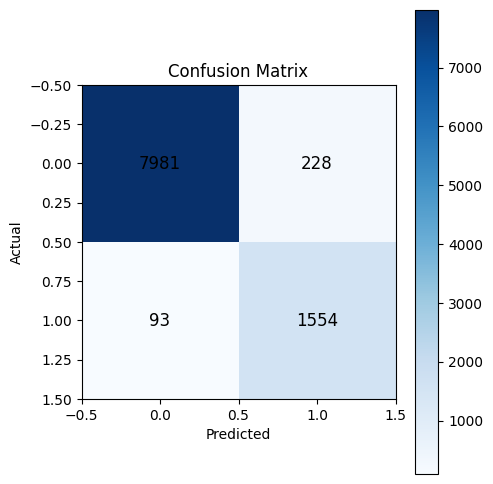

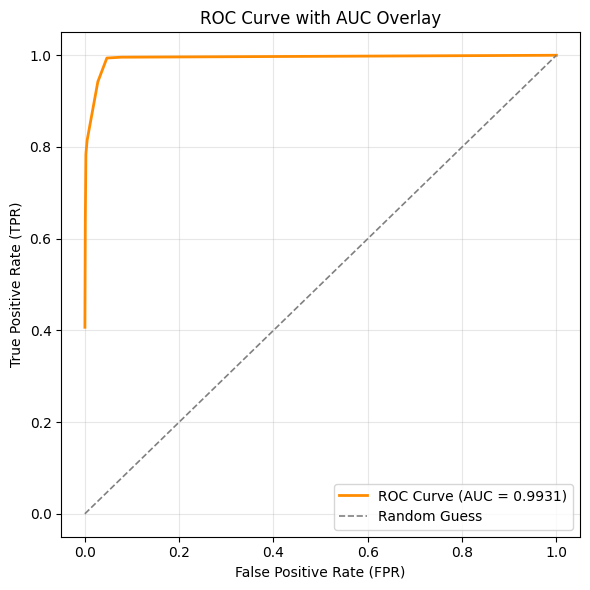

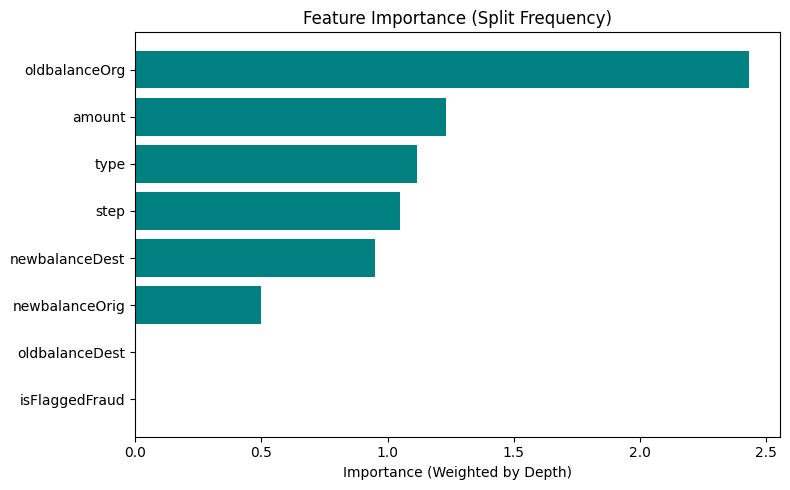


Feature Importance Table:

       Feature  Importance
 oldbalanceOrg    2.433333
        amount    1.233333
          type    1.116667
          step    1.050000
newbalanceDest    0.950000
newbalanceOrig    0.500000
oldbalanceDest    0.000000
isFlaggedFraud    0.000000


In [8]:
# Cell 8: Confusion Matrix Visualization, ROC Curve (AUC Overlay), and Feature Importance

# --- Confusion Matrix ---
plt.figure(figsize=(5, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

# --- ROC Curve ---
thresholds = np.linspace(0, 1, 100)
tpr, fpr = [], []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    tp = np.sum((y_test == 1) & (y_pred_t == 1))
    tn = np.sum((y_test == 0) & (y_pred_t == 0))
    fp = np.sum((y_test == 0) & (y_pred_t == 1))
    fn = np.sum((y_test == 1) & (y_pred_t == 0))
    tpr.append(tp / (tp + fn + 1e-10))
    fpr.append(fp / (fp + tn + 1e-10))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1.2, label='Random Guess')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve with AUC Overlay")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300)
plt.show()

# --- Feature Importance ---
def compute_importance(node, imp, depth=1):
    if node is None or node.value is not None:
        return
    imp[node.feature] += 1 / depth
    compute_importance(node.left, imp, depth + 1)
    compute_importance(node.right, imp, depth + 1)

importance = np.zeros(X.shape[1])
compute_importance(dt.root, importance)

feat_names = data.drop('isFraud', axis=1).columns
imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importance}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='teal')
plt.title("Feature Importance (Split Frequency)")
plt.gca().invert_yaxis()
plt.xlabel("Importance (Weighted by Depth)")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

print("\nFeature Importance Table:\n")
print(imp_df.to_string(index=False))


In [9]:
# -------------------------------------------
# Hyperparameter tuning with 5-fold Cross-Validation (for our custom DecisionTree)
# -------------------------------------------

max_depth_values = [3, 5, 7]
min_samples_split_values = [2, 5, 10]
min_gain_values = [1e-7, 1e-6, 1e-5]

k = 5
fold_size = len(X_train) // k
results = []

for depth in max_depth_values:
    for min_split in min_samples_split_values:
        for gain in min_gain_values:
            metrics = {"acc": [], "prec": [], "rec": [], "f1": [], "auc": []}
            
            for i in range(k):
                start = i * fold_size
                end = (i + 1) * fold_size
                
                X_val = X_train[start:end]
                y_val = y_train[start:end]
                
                X_tr = np.concatenate((X_train[:start], X_train[end:]))
                y_tr = np.concatenate((y_train[:start], y_train[end:]))
                
                # Train model with current hyperparameters
                clf = DecisionTree(max_depth=depth, min_samples_split=min_split, min_gain=gain)
                clf.fit(X_tr, y_tr)
                
                # Predict
                y_pred = clf.predict(X_val)
                y_proba = clf.predict_proba(X_val)
                
                # Compute metrics for this fold
                cm = confusion_matrix(y_val, y_pred)
                acc = np.mean(y_val == y_pred)
                prec = cm[1,1] / (cm[1,1] + cm[0,1] + 1e-10)
                rec = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-10)
                f1 = 2 * prec * rec / (prec + rec + 1e-10)
                auc = auc_score(y_val, y_proba)
                
                metrics["acc"].append(acc)
                metrics["prec"].append(prec)
                metrics["rec"].append(rec)
                metrics["f1"].append(f1)
                metrics["auc"].append(auc)
            
            # Average across folds
            results.append({
                "max_depth": depth,
                "min_samples_split": min_split,
                "min_gain": gain,
                "accuracy": np.mean(metrics["acc"]),
                "precision": np.mean(metrics["prec"]),
                "recall": np.mean(metrics["rec"]),
                "f1": np.mean(metrics["f1"]),
                "auc": np.mean(metrics["auc"]),
            })
            
            print(f"Done: depth={depth}, min_samples_split={min_split}, min_gain={gain:.0e} | Accuracy={np.mean(metrics['acc']):.4f}")

# -------------------------------------------
# Compile and display results
# -------------------------------------------
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by="f1", ascending=False).head(5)

print("\nTop 5 hyperparameter combinations by F1 Score:\n")
print(top_results.to_string(index=False))


Done: depth=3, min_samples_split=2, min_gain=1e-07 | Accuracy=0.9384
Done: depth=3, min_samples_split=2, min_gain=1e-06 | Accuracy=0.9384
Done: depth=3, min_samples_split=2, min_gain=1e-05 | Accuracy=0.9384
Done: depth=3, min_samples_split=5, min_gain=1e-07 | Accuracy=0.9384
Done: depth=3, min_samples_split=5, min_gain=1e-06 | Accuracy=0.9384
Done: depth=3, min_samples_split=5, min_gain=1e-05 | Accuracy=0.9384
Done: depth=3, min_samples_split=10, min_gain=1e-07 | Accuracy=0.9384
Done: depth=3, min_samples_split=10, min_gain=1e-06 | Accuracy=0.9384
Done: depth=3, min_samples_split=10, min_gain=1e-05 | Accuracy=0.9384
Done: depth=5, min_samples_split=2, min_gain=1e-07 | Accuracy=0.9651
Done: depth=5, min_samples_split=2, min_gain=1e-06 | Accuracy=0.9651
Done: depth=5, min_samples_split=2, min_gain=1e-05 | Accuracy=0.9651
Done: depth=5, min_samples_split=5, min_gain=1e-07 | Accuracy=0.9651
Done: depth=5, min_samples_split=5, min_gain=1e-06 | Accuracy=0.9651
Done: depth=5, min_samples_spli